In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2015
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2015-09-10,2015-09-28,14,Unknown/Unidentified,70846.53000,CDF,BUTTE,"POLYGON ((-120.67857 38.33620, -120.67856 38.3..."
1,2015-07-02,2015-07-02,7,Arson,357.59030,CDF,IONE,"POLYGON ((-121.07624 38.44155, -121.07668 38.4..."
2,2015-07-12,2015-07-12,2,Equipment Use,53.99769,CDF,MILL2,"POLYGON ((-117.04248 34.08340, -117.04256 34.0..."
3,2015-02-07,2015-02-09,9,Miscellaneous,6537.51900,CDF,ROUND,"POLYGON ((-118.65328 37.52874, -118.65219 37.5..."
4,2015-09-19,2015-09-29,7,Arson,1075.51900,CDF,TASSAJARA,"POLYGON ((-121.59807 36.40374, -121.59796 36.4..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2015-09-10,2015-09-28,14,Unknown/Unidentified,70846.53000
1,2015-07-02,2015-07-02,7,Arson,357.59030
2,2015-07-12,2015-07-12,2,Equipment Use,53.99769
3,2015-02-07,2015-02-09,9,Miscellaneous,6537.51900
4,2015-09-19,2015-09-29,7,Arson,1075.51900


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2015-09-10,2015-09-28,14,Unknown/Unidentified,70846.53000,18 days
1,2015-07-02,2015-07-02,7,Arson,357.59030,0 days
2,2015-07-12,2015-07-12,2,Equipment Use,53.99769,0 days
3,2015-02-07,2015-02-09,9,Miscellaneous,6537.51900,2 days
4,2015-09-19,2015-09-29,7,Arson,1075.51900,10 days


In [7]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,149,2015-07-09,2015-09-16,1,Lightning,37.99809,69 days
1,185,2015-07-02,2015-07-03,1,Lightning,11.14368,1 days
2,186,2015-07-21,2015-07-23,1,Lightning,15.37785,2 days
3,190,2015-08-01,2015-11-02,1,Lightning,7576.04500,93 days
4,191,2015-07-31,2015-10-31,1,Lightning,11616.88000,92 days


In [8]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,32.89,3873.80,109
2,Equipment Use,1.86,487.00,28
3,Smoking,0.00,7.47,1
4,Campfire,2.62,1935.44,8
5,Debris,22.85,63.36,13
7,Arson,6.50,493.39,8
8,Playing with fire,9.00,1970.76,3
9,Miscellaneous,15.62,4898.49,24
10,Vehicle,2.90,666.93,20


In [9]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2015.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,32.89,3873.80,109
2,Equipment Use,1.86,487.00,28
3,Smoking,0.00,7.47,1
4,Campfire,2.62,1935.44,8
5,Debris,22.85,63.36,13
7,Arson,6.50,493.39,8
8,Playing with fire,9.00,1970.76,3
10,Vehicle,2.90,666.93,20
11,Powerline,2.12,389.06,8


In [10]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,49.85,6133.61,93
1,Natural,32.89,3873.80,109


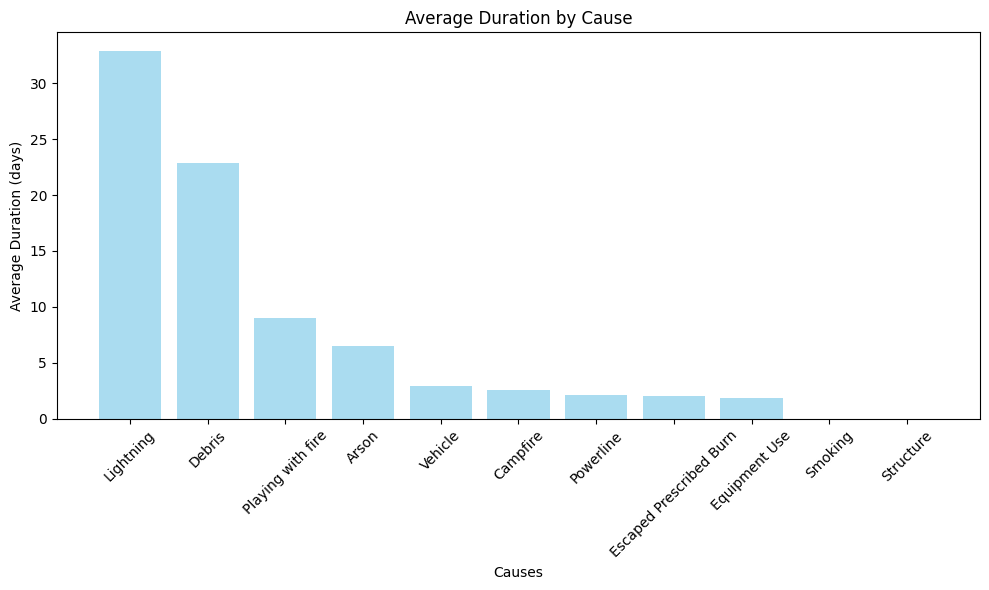

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

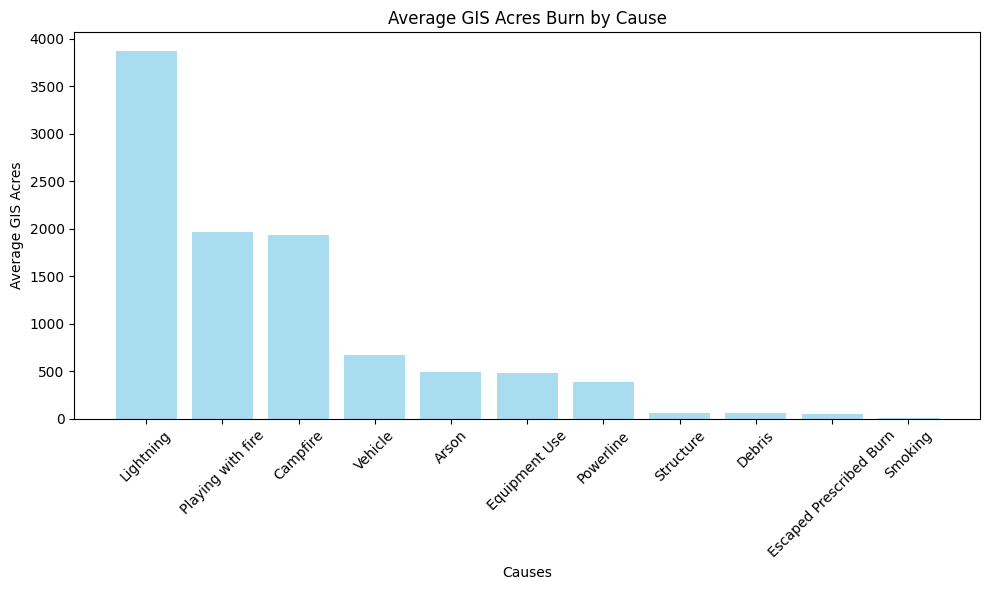

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

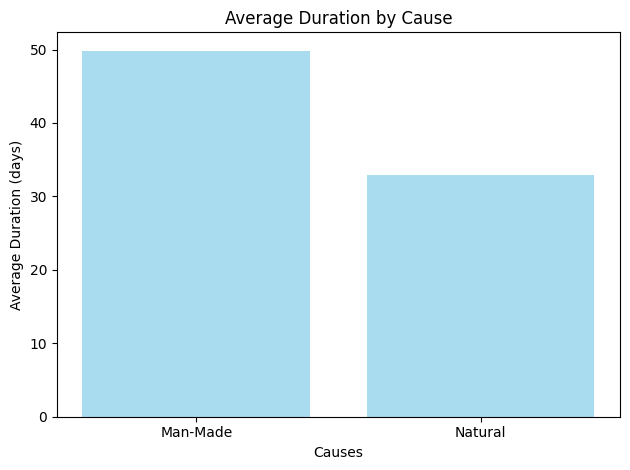

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

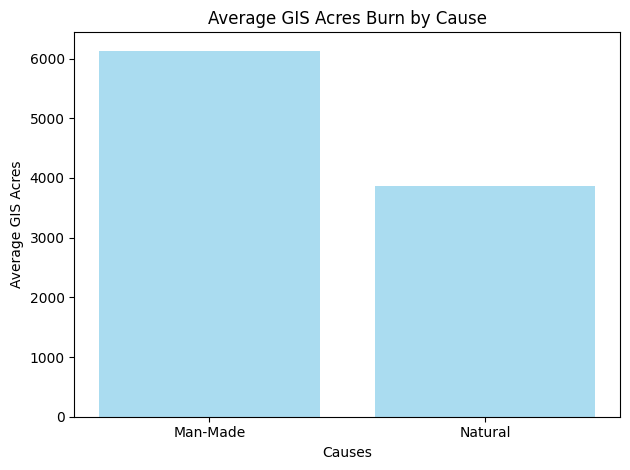

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

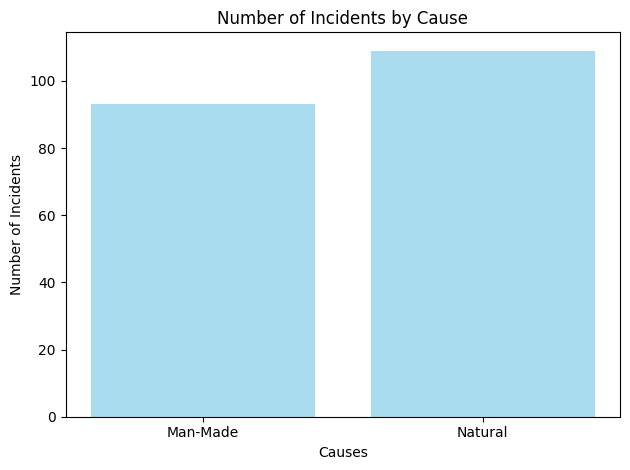

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()